# Earthquake Detection at Cook Inlet

Author: Qibin Shi, Tech support: Yiyu Ni

In [ ]:
import sys
sys.path.append('../src/denoiser/')
sys.path.append('../src/ensemble_picker/')

import gc
import glob
import h5py
import pygmt
import numpy as np
import pandas as pd

import torch
import pyocto
import seisbench.models as sbm
from ELEP.elep.ensemble_coherence import ensemble_semblance
from ELEP.elep.trigger_func import picks_summary_simple

from datetime import datetime
from das_util import try_gpu
from detect_util import *
from joblib import Parallel, delayed
from tqdm import tqdm

import obspy
from obspy import UTCDateTime, read_events
from obspy.clients.fdsn.client import Client

###
filepath = '/fd1/QibinShi_data/akdas/qibin_data/elep_pyocto/coast_only/'

## 1. Catalog Workflow for Coastal Stations Only

#### Station availability

In [ ]:
client = Client("IRIS")
t1 = UTCDateTime("2023-12-01")
t2 = UTCDateTime("2023-12-31")

inventory = client.get_stations(network="AK,AV", channel="BH?",
                                starttime=t1, endtime=t2, 
                                maxlatitude=60.1809, minlatitude=58.5911, 
                                maxlongitude=-150.6555, minlongitude=-153.7177)

#### Detect 30 days

In [ ]:
### ELEP models
devcc = try_gpu(i=1)

pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")

pn_ethz_model.to(devcc)
pn_neic_model.to(devcc)
pn_scedc_model.to(devcc)
pn_stead_model.to(devcc)
pn_geofon_model.to(devcc)
pn_instance_model.to(devcc)

pn_ethz_model.eval()
pn_neic_model.eval()
pn_scedc_model.eval()
pn_stead_model.eval()
pn_geofon_model.eval()
pn_instance_model.eval()

list_models = [pn_ethz_model,
               pn_neic_model,
               pn_scedc_model,
               pn_stead_model,
               pn_geofon_model,
               pn_instance_model]

### Loop over days
for i in range(30):
    t1 = UTCDateTime("2023-12-07") + i * 86400
    ### loop over stations
    for net in inventory:
        network = net.code

        for sta in net:
            station = sta.code
            
            print(network, station, t1)  
            
            detect_on_fly(network, station, t1, filepath, 6000, 3000, list_models, devcc)

#### Prepare picks for association

In [ ]:
### Merge picks from all stations
csv_list = glob.glob(filepath+'1month/*2023*.csv')
all_csv =[]
for i in csv_list:
    all_csv.append(pd.read_csv(i, index_col=0))
df = pd.concat(all_csv, axis=0)

# change to Octo format
df.loc[df['trace_p_arrival'].notna(), 'phase'] = "P"
sta_p_time = df.loc[df['trace_p_arrival'].notna(), ['station_code','phase','trace_p_arrival']].rename(
    columns={"station_code": "station", "trace_p_arrival": "time"})

df.loc[df['trace_s_arrival'].notna(), 'phase'] = "S"
sta_s_time = df.loc[df['trace_s_arrival'].notna(), ['station_code','phase','trace_s_arrival']].rename(
    columns={"station_code": "station", "trace_s_arrival": "time"})

picks = pd.concat(objs = [sta_p_time,sta_s_time] , axis=0)
picks['time'] = picks['time'].apply(lambda x: UTCDateTime(x).timestamp)

picks.to_csv(filepath + 'picks_octo_sta.csv', index=False)

#### Prepare stations for association

In [ ]:
layers = pd.read_csv("../models/IASP91_1.csv").iloc[:78]
pyocto.VelocityModel1D.create_model(layers, 1., 600, 400, "../models/velocity_model")

### Station table for PyOcto
# stations_table = pd.DataFrame(columns=['id','longitude','latitude', 'elevation'])
# for net in inventory:
#     for sta in net:
#         station = sta.code
#         temp = pd.DataFrame(data={'id': sta.code,
#                                   'longitude': sta.longitude,
#                                   'latitude': sta.latitude, 
#                                   'elevation': sta.elevation},index=[0])
#         stations_table = pd.concat([stations_table,temp],ignore_index=True)
stations_table = pd.read_csv(filepath + 'stations_table.csv')
picks = pd.read_csv(filepath + 'picks_octo.csv')

velocity_model = pyocto.VelocityModel1D("../models/velocity_model", tolerance=2.0)

associator = pyocto.OctoAssociator.from_area(
    lat=(57, 61),
    lon=(-155, -150),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=6,
    n_p_picks=3,
    n_s_picks=3,
    n_p_and_s_picks=2,
)
    
# associator.transform_stations(stations_table)
# stations_table.to_csv(filepath + 'stations_table.csv', index=False)
stations_table.head(), picks.head()


### Associate!

In [ ]:
# Association 
events, assignments = associator.associate(picks, stations_table)

associator.transform_events(events)
events['time'] = events['time'].apply(UTCDateTime)
all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

events.to_csv(filepath + 'events_detect_octo_staonly.csv', index=False)
all_pick_assignments.to_csv(filepath + 'all_pick_assignments_staonly.csv', index=False)

In [ ]:
### Read results
events = pd.read_csv(filepath + 'events_detect_octo_staonly.csv')
all_pick_assignments = pd.read_csv(filepath + 'all_pick_assignments_staonly.csv')
print(len(events), len(all_pick_assignments))

### Plot
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-155, -150, 57.5, 61])
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="15p,0", 
             FONT_ANNOT_PRIMARY="15p,0",
             FONT_ANNOT_SECONDARY="15p,0", 
             MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])
shade = pygmt.grdgradient(grid=grid, azimuth="0/300", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M10c",frame="a1",cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    size=(events["picks"].values + 20) * 0.005,
    fill=events['depth'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(position="JBC+w10c/0.15c+h", frame="xa50f10+levent depth (km)")
fig.show()

## 1.5 Testing DAS (download for USGS catalog events) + Stations

In [ ]:
### Cable coordinates from Ethan Williams
### We only use Ch. 500-5000
kkfls = pd.read_csv('cable_geometry/KKFLS_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)
terra = pd.read_csv('cable_geometry/TERRA_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)

### picks
filepaths = ['/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/phase_picks_0_200.hdf5',
             '/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/phase_picks_200_400.hdf5',
             '/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/phase_picks_400_555.hdf5']

raw_alldata_picks = np.concatenate([f["raw_alldata_picks"][:] for f in map(h5py.File, filepaths)])
mul_denoise_picks = np.concatenate([f["mul_denoise_picks"][:] for f in map(h5py.File, filepaths)])
pred_picks = np.concatenate([f["predicted_picks"][:] for f in map(h5py.File, filepaths)])

### catalog
cat1 = read_events("/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/denoised_catalog_0_200.xml")
cat2 = read_events("/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/denoised_catalog_200_400.xml")
cat3 = read_events("/fd1/QibinShi_data/akdas/qibin_data/plots_test_picking_dec_ch4500/denoised_catalog_400_555.xml")
cat = cat1 + cat2 + cat3

### Recording time
df_record_time = pd.read_csv('/fd1/QibinShi_data/akdas/qibin_data/recording_times_smaller.csv')
b_times = [UTCDateTime.strptime(start_t, format='decimator2_%Y-%m-%d_%H.%M.%S_UTC.h5') for start_t in df_record_time['record_time'].values]
b_times_terra = [b_terra + 0.88 for b_terra in b_times]
b_times_kkfls = [b_terra + 1.20 for b_terra in b_times]
org_times = [evt.origins[0].time - b_t for evt, b_t in zip(cat, b_times)]
pred_picks += np.array(org_times)[:, np.newaxis, np.newaxis]

### Quality control
def fit_series(s1, s2, prob, thr=0.05, vmin=0, vmax=60):
    offsets = s1-s2
    ind = np.where(np.logical_and(np.logical_and(np.logical_and(vmin<s1, s1<vmax), prob > thr), np.fabs(offsets) < 3.0))[0]
    ind_rest = np.setdiff1d(np.arange(len(s1)), ind)
    s1[ind_rest] = np.nan

    return s1, ind, ind_rest

qc_picks = np.zeros_like(mul_denoise_picks)

for i in tqdm(np.arange(len(raw_alldata_picks))):  
    qc_picks[i, :, 1, 0], ind1, ind2 = fit_series(
        mul_denoise_picks[i,:,1,0], pred_picks[i,:,1], raw_alldata_picks[i,:,1,1], thr=0.05, vmin=5, vmax=55)
    qc_picks[i, :, 0, 0], ind3, ind4 = fit_series(
        mul_denoise_picks[i,:,0,0], pred_picks[i,:,0], raw_alldata_picks[i,:,0,1], thr=0.1, vmin=5, vmax=55)
    
#### Compose tables for picks and channels
ch_dsamp = 10
ch_ind = np.arange(0, 4500, ch_dsamp)
len_cat = qc_picks.shape[0]

channel_table = pd.DataFrame(columns=['id','longitude','latitude', 'elevation'])

for ch in ch_ind:

    if ch >= 2250:  # terra
        ch1 = int(ch * 2 - 4000) 
        longitude = terra.loc[ch1, 'lon']
        latitude = terra.loc[ch1, 'lat']
        elevation = terra.loc[ch1, 'dep']
        b_t = b_times_terra
    else:  # kkfls
        ch1 = 5000 - ch * 2
        longitude = kkfls.loc[ch1, 'lon']
        latitude = kkfls.loc[ch1, 'lat']
        elevation = kkfls.loc[ch1, 'dep']
        b_t = b_times_kkfls

    temp = pd.DataFrame(data={'id': 'das'+str(ch),
                              'longitude': longitude,
                              'latitude': latitude, 
                              'elevation': elevation},index=[0])
    channel_table = pd.concat([channel_table,temp],ignore_index=True)

    p_den = [b_t[i] + qc_picks[i, ch, 0, 0] if qc_picks[i, ch, 0, 0] == qc_picks[i, ch, 0, 0] else np.nan for i in range(len_cat)]
    s_den = [b_t[i] + qc_picks[i, ch, 1, 0] if qc_picks[i, ch, 1, 0] == qc_picks[i, ch, 1, 0] else np.nan for i in range(len_cat)]

    df_deno = pd.DataFrame({
        'event_id': [' '] * len_cat,
        'source_type': [' '] * len_cat,
        'station_network_code': ['CIDAS'] * len_cat,
        'station_channel_code': [' '] * len_cat,
        'station_code': ['das'+str(ch)] * len_cat,
        'station_location_code': [' '] * len_cat,
        'station_latitude_deg': [latitude] * len_cat,
        'station_longitude_deg': [longitude] * len_cat,
        'station_elevation_m': [elevation] * len_cat,
        'trace_name': [' '] * len_cat,
        'trace_sampling_rate_hz': [25] * len_cat,
        'trace_start_time': b_t,
        'trace_S_arrival_sample': [' '] * len_cat,
        'trace_P_arrival_sample': [' '] * len_cat,
        'trace_S_onset': [' '] * len_cat,
        'trace_P_onset': [' '] * len_cat,
        'trace_snr_db': [' '] * len_cat,
        'trace_s_arrival': s_den,
        'trace_p_arrival': p_den
    })

    df_deno.to_csv(filepath+'1month/' + 'CIDAS_Ch_' + str(ch) + '_deno_qc' + '.csv')
channel_table.to_csv(filepath + 'das_channel_table.csv', index=False)

### Prepare stations, channel and picks for association

In [ ]:
### Initialize Octo
velocity_model = pyocto.VelocityModel1D("../models/velocity_model", tolerance=2.0)

associator = pyocto.OctoAssociator.from_area(
    lat=(57, 61),
    lon=(-155, -150),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=6,
    n_p_picks=0,
    n_s_picks=5,
    n_p_and_s_picks=0,
)

### DAS channel table
channel_table = pd.read_csv(filepath + 'das_channel_table.csv')[::20]
associator.transform_stations(channel_table)

### DAS picks
ch_ind = np.arange(0, 4500, 200)
all_csv =[]
for i in ch_ind:
    filename = filepath+'1month/CIDAS_Ch_' + str(i) + '_deno_qc.csv'
    all_csv.append(pd.read_csv(filename, index_col=0))
df = pd.concat(all_csv, axis=0)

# change to Octo format
df.loc[df['trace_p_arrival'].notna(), 'phase'] = "P"
sta_p_time = df.loc[df['trace_p_arrival'].notna(), ['station_code','phase','trace_p_arrival']].rename(
    columns={"station_code": "station", "trace_p_arrival": "time"})
df.loc[df['trace_s_arrival'].notna(), 'phase'] = "S"
sta_s_time = df.loc[df['trace_s_arrival'].notna(), ['station_code','phase','trace_s_arrival']].rename(
    columns={"station_code": "station", "trace_s_arrival": "time"})

picks_das = pd.concat(objs = [sta_p_time,sta_s_time] , axis=0)
picks_das['time'] = picks_das['time'].apply(lambda x: UTCDateTime(x).timestamp)

picks_das.to_csv(filepath + 'picks_octo_das_qc.csv', index=False)

### Coastal data
picks_sta = pd.read_csv(filepath + 'picks_octo_sta.csv')
sta_table = pd.read_csv(filepath + 'stations_table.csv')

### Merge DAS and Sta
picks = pd.concat([picks_sta, picks_das], axis=0, ignore_index=True)
stations_table = pd.concat([sta_table, channel_table], axis=0, ignore_index=True)

### Associate !

In [ ]:
# Association 
events, assignments = associator.associate(picks, stations_table)
print(len(events), len(assignments))

associator.transform_events(events)
events['time'] = events['time'].apply(UTCDateTime)
all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

events.to_csv(filepath + 'events_detect_octo_qc1.csv', index=False)
all_pick_assignments.to_csv(filepath + 'all_pick_assignments_qc1.csv', index=False)

In [ ]:
### Read the results
events = pd.read_csv(filepath + 'events_detect_octo_qc1.csv')
all_pick_assignments = pd.read_csv(filepath + 'all_pick_assignments_qc1.csv')

### Plot
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-155, -150, 57.5, 61])
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="15p,0", FONT_ANNOT_PRIMARY="15p,0",
             FONT_ANNOT_SECONDARY="15p,0", MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])

shade = pygmt.grdgradient(grid=grid, azimuth="0/300", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M10c",frame="a1",cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    size=(events["picks"].values + 20) * 0.005,
    fill=events['depth'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(position="JBC+w10c/0.15c+h", frame="xa50f10+levent depth (km)")
fig.show()

# 2. Catalog Workflow for DAS (continuous data) + Coastal Stations

In [1]:
import sys
sys.path.append('../src/denoiser/')
sys.path.append('../src/ensemble_picker/')

import gc
import glob
import h5py
import pygmt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import pyocto
import seisbench.models as sbm
from ELEP.elep.ensemble_coherence import ensemble_semblance
from ELEP.elep.trigger_func import picks_summary_simple

from datetime import datetime
from das_util import *
from detect_util import *
from das_denoise_models import unet
from joblib import Parallel, delayed
from tqdm import tqdm
from scipy.signal import filtfilt, butter
from scipy.interpolate import interp1d

import obspy
from obspy import UTCDateTime, read_events
from obspy.clients.fdsn.client import Client

###
filepath = '/fd1/QibinShi_data/akdas/qibin_data/elep_pyocto/coast_only/'

### Initialize Octo
velocity_model = pyocto.VelocityModel1D("../models/velocity_model", tolerance=2.0)

associator = pyocto.OctoAssociator.from_area(
    lat=(57, 61),
    lon=(-155, -150),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=5,
    n_p_picks=0,
    n_s_picks=3,
    n_p_and_s_picks=0,
)

/home/qibins/anaconda3/envs/denoise/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/qibins/anaconda3/envs/denoise/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Read -- Denoise -- Pick -- Save (Don't run here because we have it on edge)

In [ ]:
################################ Read the data ################################
rawdata_dir = '/home/niyiyu/Research/DAS-NIR/datasets/earthquakes_raw/11720793/'
kkfls_dir = rawdata_dir + 'KKFL-S/'
terra_dir = rawdata_dir + 'TERRA/'
kkfls_files = glob.glob(kkfls_dir + 'decimator2_*.h5')
terra_files = glob.glob(terra_dir + 'decimator2_*.h5')
kkfls_files.sort()
terra_files.sort()

kkfls_data = np.zeros((len(kkfls_files), 4500, 1500), dtype=np.float32)
terra_data = np.zeros((len(terra_files), 4500, 1500), dtype=np.float32)
kkfls_btimes = np.zeros(len(kkfls_files), dtype=object)
terra_btimes = np.zeros(len(terra_files), dtype=object)

for i, kkfls_file in enumerate(kkfls_files):
    with h5py.File(kkfls_file, 'r') as f:
        time_data = f['Acquisition']['Raw[0]']['RawData'][:1500, 500:5000]
        kkfls_data[i, :time_data.shape[1], :time_data.shape[0]] = time_data.T
        kkfls_btimes[i] = datetime.utcfromtimestamp(f['Acquisition']['Raw[0]']['RawDataTime'][0]/1e6)
for i, terra_file in enumerate(terra_files):
    with h5py.File(terra_file, 'r') as f:
        time_data = f['Acquisition']['Raw[0]']['RawData'][:1500, 500:5000]
        terra_data[i, :time_data.shape[1], :time_data.shape[0]] = time_data.T
        terra_btimes[i] = datetime.utcfromtimestamp(f['Acquisition']['Raw[0]']['RawDataTime'][0]/1e6)

### merge two arrays and filter
rawdata = np.append(kkfls_data[:, ::-1, :], terra_data[:,:,:], axis=1)
rawdata = np.nan_to_num(rawdata)

### Bandpass filter
b, a = butter(4, (0.5, 12), fs=25, btype='bandpass')
filt = filtfilt(b, a, rawdata, axis=2)
rawdata = filt / np.std(filt, axis=(1,2), keepdims=True)  ## Rawdata w.r.t. Denoised 

################################ Denoise the data ################################
""" Initialize the U-net model """
devc = try_gpu(i=0)

model_1 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
model_1 = nn.DataParallel(model_1, device_ids=[0])
model_1.to(devc)

""" Load the pretrained weights """
model_1.load_state_dict(torch.load('../models/checkpoint_noatt_LRdecays0.8_mask0.5_raw2raw_chmax4500.pt'))  # raw2raw
model_1.eval() 

""" Denoise """
one_denoised = np.zeros_like(rawdata)
mul_denoised = np.zeros_like(rawdata)

for eid in np.arange(len(rawdata)):
    one_denoised[eid,:,:], mul_denoised[eid,:,:] = Denoise_largeDAS(rawdata[eid], 
                                                                    model_1, 
                                                                    devc, 
                                                                    repeat=4, 
                                                                    norm_batch=False)
# %matplotlib inline
# vizRawDenoise(rawdata[:,::100,:], one_denoised[:,::100,:], mul_denoised[:,::100,:], index=range(21,23), model="raw-raw")

################################ Pick phases ################################
### Interpolate to 6000 samples
interp_func = interp1d(np.linspace(0, 1, 1500), mul_denoised, axis=-1, kind='linear')
interpolated_muldenoised = interp_func(np.linspace(0, 1, 6000))

### ELEP parameters
paras_semblance = {'dt':0.01, 
                   'semblance_order':2, 
                   'window_flag':True, 
                   'semblance_win':0.5, 
                   'weight_flag':'max'}

### ELEP models
devcc = try_gpu(i=0)

pn_ethz_model = sbm.EQTransformer.from_pretrained("ethz")
pn_neic_model = sbm.EQTransformer.from_pretrained("neic")
pn_scedc_model = sbm.EQTransformer.from_pretrained("scedc")
pn_stead_model = sbm.EQTransformer.from_pretrained("stead")
pn_geofon_model = sbm.EQTransformer.from_pretrained("geofon")
pn_instance_model = sbm.EQTransformer.from_pretrained("instance")

pn_ethz_model.to(devcc); pn_ethz_model.eval()
pn_neic_model.to(devcc); pn_neic_model.eval()
pn_scedc_model.to(devcc); pn_scedc_model.eval()
pn_stead_model.to(devcc); pn_stead_model.eval()
pn_geofon_model.to(devcc); pn_geofon_model.eval()
pn_instance_model.to(devcc); pn_instance_model.eval()

list_models = [pn_ethz_model,
               pn_neic_model,
               pn_scedc_model,
               pn_stead_model,
               pn_geofon_model,
               pn_instance_model]

### Picking
fs=100; dchan=9.5714
ch_itv=1000  # data are downsampled to pick
nsta = interpolated_image.shape[1] // ch_itv
mul_picks = np.zeros([len(rawdata), nsta, 2, 2], dtype = np.float32)

for i in tqdm(np.arange(len(rawdata))):
    ### Pick mulDENOISED 
    image = np.nan_to_num(interpolated_muldenoised[i,::ch_itv,:])
    mul_picks[i,:,:,:] = apply_elep(image, list_models, fs, paras_semblance, devcc)


################################ Save phases ################################
### Cable coordinates from Ethan Williams
### We only use Ch. 500-5000
kkfls = pd.read_csv('cable_geometry/KKFLS_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)
terra = pd.read_csv('cable_geometry/TERRA_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)

### convert and save
thr = 0.05
ch_ind = np.arange(raw_picks.shape[1])
len_cat = raw_picks.shape[0]

for ch in ch_ind:

    if ch > 22:  # terra
        ch1 = int(ch * 200 - 4000) 
        longitude = terra.loc[ch1, 'lon']
        latitude = terra.loc[ch1, 'lat']
        elevation = terra.loc[ch1, 'dep']
        b_t = terra_btimes
    else:  # kkfls
        ch1 = 5000 - ch * 200
        longitude = kkfls.loc[ch1, 'lon']
        latitude = kkfls.loc[ch1, 'lat']
        elevation = kkfls.loc[ch1, 'dep']
        b_t = kkfls_btimes

    p_den = [b_t[i] + timedelta(seconds=np.float64(mul_picks[i, ch, 0, 0])) if mul_picks[i, ch, 0, 1] > thr else np.nan for i in range(len_cat)]
    s_den = [b_t[i] + timedelta(seconds=np.float64(mul_picks[i, ch, 1, 0])) if mul_picks[i, ch, 1, 1] > thr else np.nan for i in range(len_cat)]
    
    df_deno = pd.DataFrame({
        'event_id': [' '] * len_cat,
        'source_type': [' '] * len_cat,
        'station_network_code': ['CIDAS'] * len_cat,
        'station_channel_code': [' '] * len_cat,
        'station_code': ['das'+str(ch*100)] * len_cat,
        'station_location_code': [' '] * len_cat,
        'station_latitude_deg': [latitude] * len_cat,
        'station_longitude_deg': [longitude] * len_cat,
        'station_elevation_m': [elevation] * len_cat,
        'trace_name': [' '] * len_cat,
        'trace_sampling_rate_hz': [25] * len_cat,
        'trace_start_time': b_t,
        'trace_S_arrival_sample': [' '] * len_cat,
        'trace_P_arrival_sample': [' '] * len_cat,
        'trace_S_onset': [' '] * len_cat,
        'trace_P_onset': [' '] * len_cat,
        'trace_snr_db': [' '] * len_cat,
        'trace_s_arrival': s_den,
        'trace_p_arrival': p_den
    })
    df_deno.to_csv(filepath+'1hour/' + 'CIDAS_Ch_' + str(ch) + '_deno' + '.csv')

### Prepare for association

1. QC: removing P picks that are too close to S
2. QC: change P to S when S is not picked
3. QC: remove picks near the boundaries of the window

In [ ]:
### Initialize Octo
velocity_model = pyocto.VelocityModel1D("../models/velocity_model", tolerance=2.0)

associator = pyocto.OctoAssociator.from_area(
    lat=(57, 61),
    lon=(-155, -150),
    zlim=(0, 200),
    time_before=300,
    velocity_model=velocity_model,
    n_picks=5,
    n_p_picks=0,
    n_s_picks=3,
    n_p_and_s_picks=0,
)

### Regenerate channel table for edge cases (because we made mistake for ch numbering on edge)
### Cable coordinates from Ethan Williams
### We only use Ch. 500-5000
kkfls = pd.read_csv('cable_geometry/KKFLS_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)
terra = pd.read_csv('cable_geometry/TERRA_coords.xycz',header=None,names=['lon','lat','cha','dep'],delim_whitespace=True)
ch_itv = 500
sel_ch = np.arange(int(ch_itv/2), 9000, ch_itv)
nsta = len(sel_ch)
channel_table = pd.DataFrame(columns=['id','longitude','latitude', 'elevation'])
for ic in np.arange(nsta):

    if sel_ch[ic] >= 4500:  # terra
        ch1 = int(sel_ch[ic] - 4000) 
        longitude = terra.loc[ch1, 'lon']
        latitude = terra.loc[ch1, 'lat']
        elevation = terra.loc[ch1, 'dep']
    else:  # kkfls
        ch1 = 5000 - sel_ch[ic]
        longitude = kkfls.loc[ch1, 'lon']
        latitude = kkfls.loc[ch1, 'lat']
        elevation = kkfls.loc[ch1, 'dep']

    temp = pd.DataFrame(data={'id': 'das'+str(ic*100), ## here is to match the mistake
                              'longitude': longitude,
                              'latitude': latitude, 
                              'elevation': elevation},index=[0])
    channel_table = pd.concat([channel_table,temp],ignore_index=True)
associator.transform_stations(channel_table)
channel_table.to_csv(filepath + 'das_channel_table_edge.csv', index=False)

### DAS picks QC, remove bad P
csv_list = sorted(glob.glob(filepath+'1hour/CIDAS_202312??_??_deno.csv'))
all_csv =[]
for i in csv_list:
    all_csv.append(pd.read_csv(i, index_col=0))
df = pd.concat(all_csv, axis=0)

### P nan, S not nan
df_s = df.dropna(subset=['trace_s_arrival'], how='all', inplace=False)
df_s = df_s[df_s['trace_p_arrival'].isna()]

### P not nan, S nan
df_p = df.dropna(subset=['trace_p_arrival'], how='all', inplace=False)
df_p = df_p[df_p['trace_s_arrival'].isna()]
df_p['trace_s_arrival'] = df_p['trace_p_arrival']
df_p['trace_p_arrival'] = np.nan

### P S not nan
df_ps = df.dropna(subset=['trace_p_arrival'], how='all', inplace=False)
df_ps.dropna(subset=['trace_s_arrival'], how='all', inplace=True)
df_ps['delay'] = df_ps['trace_s_arrival'].apply(lambda x: UTCDateTime(x).timestamp) - df_ps['trace_p_arrival'].apply(lambda x: UTCDateTime(x).timestamp)
df_ps.loc[df_ps['delay'] < 0.5, 'trace_p_arrival'] = np.nan
df_ps.drop(columns=['delay'], inplace=True)

df = pd.concat([df_s, df_p, df_ps], axis=0)

# change to Octo format
df.loc[df['trace_p_arrival'].notna(), 'phase'] = "P"
sta_p_time = df.loc[df['trace_p_arrival'].notna(), ['station_code','phase','trace_p_arrival']].rename(
    columns={"station_code": "station", "trace_p_arrival": "time"})
df.loc[df['trace_s_arrival'].notna(), 'phase'] = "S"
sta_s_time = df.loc[df['trace_s_arrival'].notna(), ['station_code','phase','trace_s_arrival']].rename(
    columns={"station_code": "station", "trace_s_arrival": "time"})

picks_das = pd.concat(objs = [sta_p_time,sta_s_time] , axis=0)
picks_das['sec'] = picks_das['time'].apply(lambda x: int(UTCDateTime(x).strftime('%S')))

### QC: removing picks at the boundaries of windows
picks_das = picks_das[~picks_das['sec'].between(53, 59)]
picks_das = picks_das.drop(columns=['sec'])

picks_das['time'] = picks_das['time'].apply(lambda x: UTCDateTime(x).timestamp)
picks_das.to_csv(filepath + 'picks_octo_das.csv', index=False)

#### Associate

In [ ]:
### Read picks and stations
picks_sta = pd.read_csv(filepath + 'picks_octo_sta.csv')
picks_das = pd.read_csv(filepath + 'picks_octo_das.csv')
sta_table = pd.read_csv(filepath + 'stations_table.csv')
channel_table = pd.read_csv(filepath + 'das_channel_table_edge.csv')
picks_sta_subset = picks_sta[picks_sta['time'] < UTCDateTime(2023, 12, 15, 21, 59, 59).timestamp]

### Merge
stations_table = pd.concat([sta_table, channel_table], axis=0, ignore_index=True)
picks = pd.concat([picks_sta_subset, picks_das], axis=0, ignore_index=True)


### Associations

### Using DAS+STA
events, assignments = associator.associate(picks, stations_table)

associator.transform_events(events)
events['time'] = events['time'].apply(UTCDateTime)
all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

events.to_csv(filepath + 'events_detect_das_sta.csv', index=False)
all_pick_assignments.to_csv(filepath + 'all_pick_assignments_das_sta.csv', index=False)

### Using STA only
events, assignments = associator.associate(picks_sta_subset, sta_table)

associator.transform_events(events)
events['time'] = events['time'].apply(UTCDateTime)
all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))

events.to_csv(filepath + 'events_detect_sta.csv', index=False)
all_pick_assignments.to_csv(filepath + 'all_pick_assignments_sta.csv', index=False)

#### Plot DAS+STA catalog

In [ ]:
### Read the results
events = pd.read_csv(filepath + 'events_detect_das_sta.csv')
all_pick_assignments = pd.read_csv(filepath + 'all_pick_assignments_das_sta.csv')

### discard events with no sta picks
id_to_discard = []
for idx in events['idx'].to_numpy():
    assign_picks = all_pick_assignments[all_pick_assignments['idx']==idx]
    
    contains_das = all('das' in station for station in assign_picks['station'])
    if contains_das:
        id_to_discard.append(idx)

events = events[~events['idx'].isin(id_to_discard)]
events.to_csv(filepath + 'events_detect_das_sta_new.csv', index=False)

### Plot
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-155, -150, 57, 61])
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="15p,0", FONT_ANNOT_PRIMARY="15p,0",
             FONT_ANNOT_SECONDARY="15p,0", MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])

shade = pygmt.grdgradient(grid=grid, azimuth="0/300", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M10c",frame="a1",cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    size=(events["picks"].values + 20) * 0.005,
    fill=events['depth'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(position="JBC+w10c/0.15c+h", frame="xa50f10+levent depth (km)")
fig.show()

#### Plot STA only catalog

In [ ]:
### Read the results
events = pd.read_csv(filepath + 'events_detect_sta.csv')
all_pick_assignments = pd.read_csv(filepath + 'all_pick_assignments_sta.csv')
events = events[events['depth']>5]

### Plot
grid = pygmt.datasets.load_earth_relief(resolution="30s", region=[-155, -150, 57.5, 61])
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="15p,0", FONT_ANNOT_PRIMARY="15p,0",
             FONT_ANNOT_SECONDARY="15p,0", MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])

shade = pygmt.grdgradient(grid=grid, azimuth="0/300", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M10c",frame="a1",cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    size=(events["picks"].values + 20) * 0.005,
    fill=events['depth'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(position="JBC+w10c/0.15c+h", frame="xa50f10+levent depth (km)")
fig.show()

## 2.5 Compare catalogs

1. DAS+STA vs STA
2. DAS+STA vs ANSS

#### DAS+STA vs STA

In [ ]:
events1 = pd.read_csv(filepath + 'events_detect_das_sta_new.csv')
events2 = pd.read_csv(filepath + 'events_detect_sta.csv')

events1['time'] = events1['time'].apply(lambda x: UTCDateTime(x).timestamp)
events2['time'] = events2['time'].apply(lambda x: UTCDateTime(x).timestamp)

matched = []
for i in np.arange(len(events1)):
    for j in np.arange(len(events2)):
        if np.abs(events1.loc[i, 'time'] - events2.loc[j, 'time']) < 10.0:
            matched.append([i,j])
matched = np.array(matched)

matched_idx = np.unique(matched[:,0])
unmatched_idx = np.setdiff1d(np.arange(len(events1)), matched_idx)
unmatched_events = events1.loc[unmatched_idx]   


In [ ]:
### Plot
grid = pygmt.datasets.load_earth_relief(resolution="01m", region=[-155, -150, 57, 61])
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="15p,0", FONT_ANNOT_PRIMARY="15p,0",
             FONT_ANNOT_SECONDARY="15p,0", MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])

shade = pygmt.grdgradient(grid=grid, azimuth="0/300", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M10c",frame="a1",cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])
fig.plot(
    x=unmatched_events["longitude"].values,
    y=unmatched_events["latitude"].values,
    size=(unmatched_events["picks"].values) * 0.1,
    fill=unmatched_events['depth'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(position="JBC+w10c/0.15c+h", frame="xa50f10+levent depth (km)")
fig.show()

### DAS+STA vs ANSS (USGS)

In [4]:
anss = pd.read_csv('Dec2023_CookInlet.csv')
anss['time'] = anss['time'].apply(lambda x: UTCDateTime(x).timestamp)
events1 = pd.read_csv(filepath + 'events_detect_das_sta_new.csv')
events1['time'] = events1['time'].apply(lambda x: UTCDateTime(x).timestamp)

matched = []
for i in np.arange(len(events1)):
    for j in np.arange(len(anss)):
        if np.abs(events1.loc[i, 'time'] - anss.loc[j, 'time']) < 10.0:
            matched.append([i,j])
matched = np.array(matched)

matched_idx = np.unique(matched[:,0])
unmatched_idx = np.setdiff1d(np.arange(len(events1)), matched_idx)
unmatched_events = events1.loc[unmatched_idx]  
unmatched_events

,idx,time,x,y,z,picks,latitude,longitude,depth
2,2,1.701401e+09,18.395457,112.927838,54.296875,5,60.013268,-152.170199,54.296875
3,3,1.701410e+09,23.142672,112.927838,51.953125,11,60.013028,-152.085092,51.953125
4,4,1.701410e+09,13.648242,96.296866,3.515625,25,59.864179,-152.256405,3.515625
5,5,1.701412e+09,71.801622,119.930352,34.765625,5,60.070246,-151.210443,34.765625
8,8,1.701419e+09,-16.021850,162.820753,74.609375,15,60.461168,-152.791193,74.609375
...,...,...,...,...,...,...,...,...,...
297,304,1.702604e+09,26.703083,42.902693,39.453125,6,59.384282,-152.030151,39.453125
298,305,1.702610e+09,-0.593402,224.968069,187.890625,13,61.019237,-152.510974,187.890625
305,312,1.702655e+09,-57.559978,68.286808,10.546875,11,59.609020,-153.519561,10.546875
308,315,1.702659e+09,12.461439,-139.162683,142.578125,8,57.750434,-152.290718,142.578125


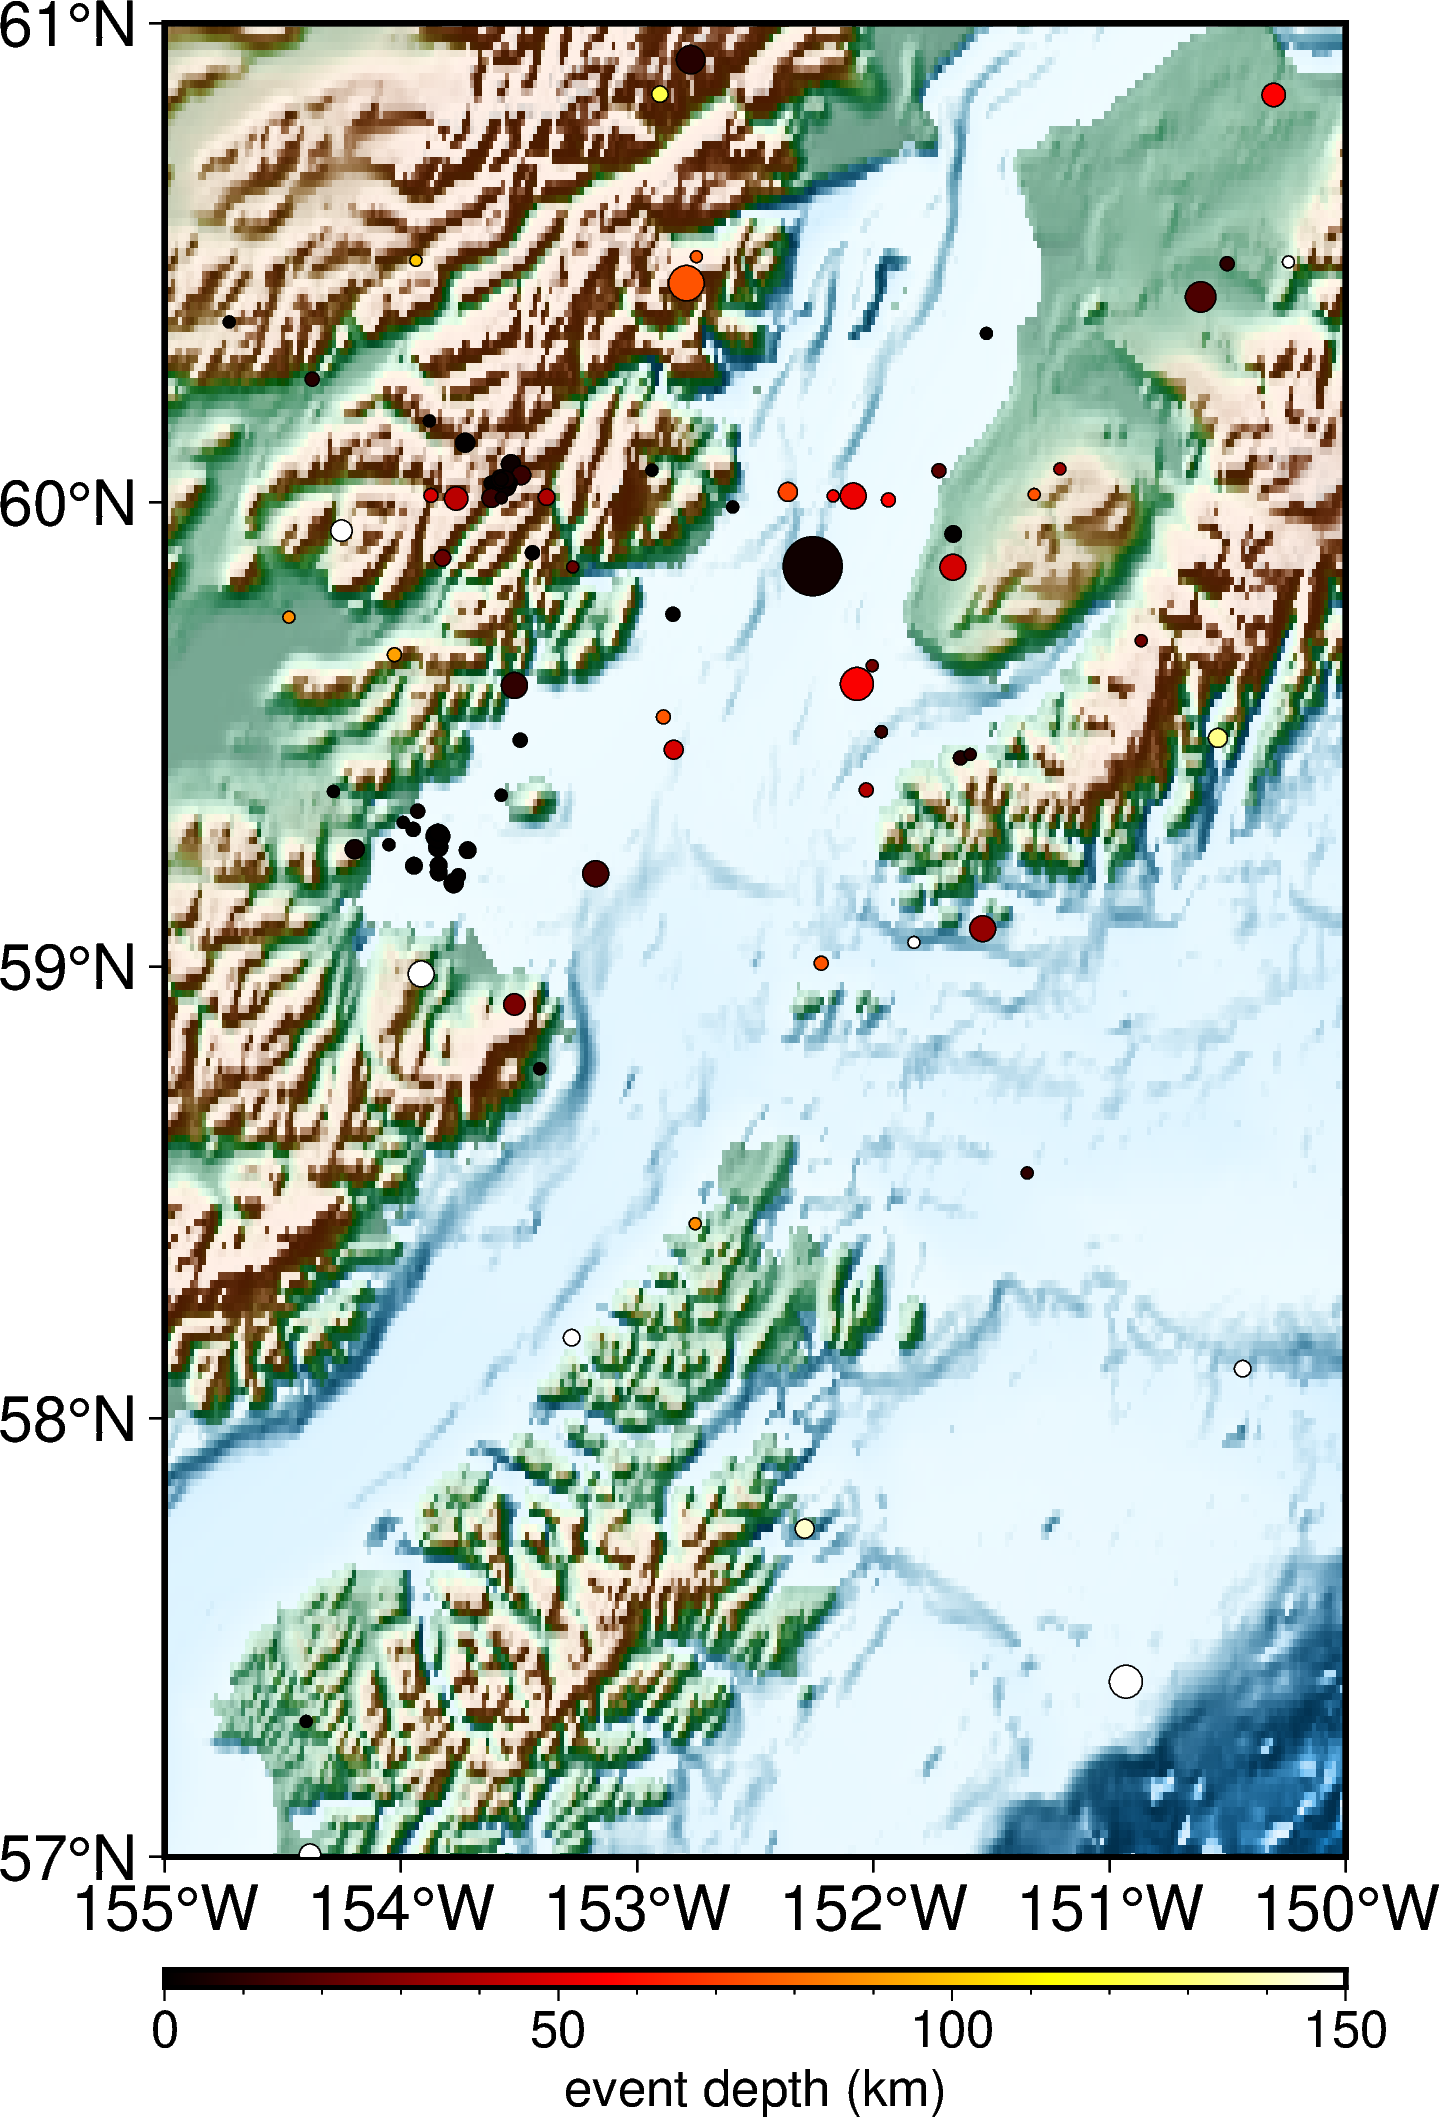

In [3]:
### Plot
grid = pygmt.datasets.load_earth_relief(resolution="01m", region=[-155, -150, 57, 61])
fig = pygmt.Figure()
pygmt.config(FONT_LABEL="15p,0", FONT_ANNOT_PRIMARY="15p,0",
             FONT_ANNOT_SECONDARY="15p,0", MAP_FRAME_TYPE="plain")
pygmt.makecpt(cmap="terra", series=[-7000, 3000])

shade = pygmt.grdgradient(grid=grid, azimuth="0/300", normalize="e1")
fig.grdimage(grid=grid,shading=shade,projection="M10c",frame="a1",cmap=True)

pygmt.makecpt(cmap="hot", series=[0, 150])
fig.plot(
    x=unmatched_events["longitude"].values,
    y=unmatched_events["latitude"].values,
    size=(unmatched_events["picks"].values) * 0.02,
    fill=unmatched_events['depth'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(position="JBC+w10c/0.15c+h", frame="xa50f10+levent depth (km)")
fig.show()

In [5]:
check_events = unmatched_events[unmatched_events['depth']<120]
check_events = check_events[check_events['latitude'] < 60.0]
check_events = check_events[check_events['latitude'] > 59.5]
check_events = check_events[check_events['longitude'] < -151.5]
check_events = check_events[check_events['longitude'] > -152.5]
check_events['time'] = check_events['time'].apply(lambda x: UTCDateTime(x))
check_events.sort_values(by='picks', ascending=False)

,idx,time,x,y,z,picks,latitude,longitude,depth
4,4,2023-12-01T05:51:05.849096Z,13.648242,96.296866,3.515625,25,59.864179,-152.256405,3.515625
162,166,2023-12-09T06:46:12.982939Z,24.329475,68.286808,55.078125,14,59.612277,-152.069019,55.078125
35,38,2023-12-02T20:46:17.072360Z,46.878745,96.296866,46.484375,11,59.861747,-151.663353,46.484375
230,236,2023-12-12T09:17:11.016847Z,46.878745,104.174695,0.390625,7,59.932450,-151.661573,0.390625
32,34,2023-12-02T14:57:24.549478Z,30.263494,56.907722,0.390625,5,59.509752,-151.965527,0.390625
211,217,2023-12-11T16:38:41.993750Z,30.263494,56.907722,12.890625,5,59.509752,-151.965527,12.890625
312,319,2023-12-15T19:36:05.891870Z,27.889886,72.663380,25.390625,5,59.651338,-152.005374,25.390625


In [11]:
assignments = pd.read_csv(filepath + 'all_pick_assignments_das_sta.csv')
assignments['time_pick'] = assignments['time_pick'].apply(lambda x: UTCDateTime(x))
assignments[assignments['idx']==166]

,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
2451,166,2023-12-09T06:46:12.982939Z,24.329475,68.286808,55.078125,14,59.612277,-152.069019,55.078125,166,3087,0.225685,BRLK,P,2023-12-09T06:46:23.608400Z
2452,166,2023-12-09T06:46:12.982939Z,24.329475,68.286808,55.078125,14,59.612277,-152.069019,55.078125,166,7829,0.177332,BRLK,S,2023-12-09T06:46:31.388400Z
2453,166,2023-12-09T06:46:12.982939Z,24.329475,68.286808,55.078125,14,59.612277,-152.069019,55.078125,166,3101,0.044777,BRSE,P,2023-12-09T06:46:24.228400Z
2454,166,2023-12-09T06:46:12.982939Z,24.329475,68.286808,55.078125,14,59.612277,-152.069019,55.078125,166,7845,0.303768,BRSE,S,2023-12-09T06:46:32.928400Z
2455,166,2023-12-09T06:46:12.982939Z,24.329475,68.286808,55.078125,14,59.612277,-152.069019,55.078125,166,3120,-0.316383,CNP,P,2023-12-09T06:46:21.668400Z
2456,166,2023-12-09T06:46:12.982939Z,24.329475,68.286808,55.078125,14,59.612277,-152.069019,55.078125,166,7858,-0.977555,CNP,S,2023-12-09T06:46:27.768400Z
2457,166,2023-12-09T06:46:12.982939Z,24.329475,68.286808,55.078125,14,59.612277,-152.069019,55.078125,166,3207,0.085523,ILCB,P,2023-12-09T06:46:28.220000Z
2458,166,2023-12-09T06:46:12.982939Z,24.329475,68.286808,55.078125,14,59.612277,-152.069019,55.078125,166,7898,0.416047,ILCB,S,2023-12-09T06:46:40.060000Z
2459,166,2023-12-09T06:46:12.982939Z,24.329475,68.286808,55.078125,14,59.612277,-152.069019,55.078125,166,7950,-0.874326,ILNE,S,2023-12-09T06:46:41.640000Z
2460,166,2023-12-09T06:46:12.982939Z,24.329475,68.286808,55.078125,14,59.612277,-152.069019,55.078125,166,3329,0.571973,ILS,P,2023-12-09T06:46:29.660000Z
